In [17]:
# ## The imports
#the usuals
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
from datetime import timedelta
from math import sqrt
import importlib
from tqdm import tqdm
import joblib

In [18]:

# plots
from matplotlib import style
style.use('default')

# Modeling
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.models import load_model

from sklearn.linear_model import LinearRegression

In [19]:
# Our custom utility functions
import utils
utils = importlib.reload(utils) #reload if utils.py is modified.
from utils import csvfileread, read_and_rename,create_dataset,convert_timestamp
from utils import atoi, natural_keys
from utils import load_electricity_demand_data
from utils import load_weather_data
from utils import train_LSTM_v1_on_features
from utils import get_dataset_with_condition

In [20]:
# Transformer-specific imports
from tensorflow.keras import layers, Model
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

In [21]:
# ## Load and preprocess electricity demand data (ERCOT)

df_scada = load_electricity_demand_data(data_path='Data/Native_*.xlsx')


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:23<00:00,  3.93s/it]


In [22]:
df_scada.head(n=2)


,timestamp,ERCOT
0,2018-01-01 01:00:00,50567.069682
1,2018-01-01 02:00:00,50617.087977


In [23]:
df_scada.tail(n=2)

,timestamp,ERCOT
52575,2023-12-31 23:00:00,42244.587370
52576,2024-01-01 00:00:00,41621.968883


In [24]:
df_scada.shape

(52577, 2)

In [25]:
# Save the sorted DataFrame to a '.csv' file
df_scada.to_csv('var/2018_to_2023_electricity_demand_data.csv', index=False)


In [26]:
# ## Load different weather data

df_weather = load_weather_data(data_path='Data/Hourly weather data/asos_hourly_*x.csv')


In [27]:
# Display the merged dataframe
df_weather.head(n=2)

,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3
0,2016-01-01 00:00:00,10.353333,89.003333,5.750000,50.60,0.0,NaN,NaN,3.833333,NaN,0.0,11.666667,63.646667,7.666667,53.00,0.0
1,2016-01-01 01:00:00,10.560000,88.620000,3.066667,50.96,0.0,NaN,NaN,1.533333,NaN,0.0,10.333333,76.350000,8.050000,48.27,0.0


In [28]:
df_weather.tail(n=2)

,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3
73846,2024-06-03 22:00:00,37.443333,48.316667,13.80,115.000000,0.0,27.333333,80.420000,3.833333,88.486667,0.000000,31.666667,67.85,16.10,101.666667,0.0
73847,2024-06-03 23:00:00,34.776667,63.433333,14.95,114.666667,0.0,22.666667,86.826667,3.833333,72.800000,0.083333,31.000000,70.45,14.95,99.920000,0.0


In [29]:
# Please note:
# 
# 
# 
# | Weather | field1 | field2 | field3 | field4 |
# | -------- | ------- | -------- | ------- |  ------- |
# | **BKS:** | `tmpc_1` | `relh_1` | `sped_1` | `feel_1` |
# | **JDD:** | `tmpc_2` | `relh_2` |  `sped_2` | `feel_2` |
# | **TME:** | `tmpc_3` | `relh_3` | `sped_3` |`feel_3` |

In [30]:
# ## Join Electricity Demand data with weather data

df_scada['timestamp'] = pd.to_datetime(df_scada['timestamp'])
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

In [31]:
df_scada.shape, df_weather.shape

((52577, 2), (73848, 16))

In [32]:
# Merge df_scada with df_weather on 'timestamp'
merged_df = pd.merge( df_weather, df_scada, on='timestamp')

In [33]:
merged_df.head(n=2)

,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3,ERCOT
0,2018-01-01 01:00:00,9.646667,91.63,11.5,47.323333,0.083333,-2.666667,65.06,8.816667,18.483333,0.0,3.333333,88.873333,15.716667,29.016667,0.0,50567.069682
1,2018-01-01 02:00:00,6.890000,91.33,16.1,37.216667,0.000000,-3.000000,63.27,9.966667,17.100000,0.0,3.000000,86.690000,16.100000,28.130000,0.0,50617.087977


In [34]:
merged_df.tail(n=2)

,timestamp,tmpc_1,relh_1,sped_1,feel_1,p01m_1,tmpc_2,relh_2,sped_2,feel_2,p01m_2,tmpc_3,relh_3,sped_3,feel_3,p01m_3,ERCOT
52575,2023-12-31 23:00:00,24.276667,57.093333,9.20,75.700000,0.0,13.333333,53.36,0.0,56.0,0.0,19.666667,68.67,8.433333,67.4,0.0,42244.587370
52576,2024-01-01 00:00:00,21.906667,70.933333,8.05,71.433333,0.0,10.333333,60.53,0.0,50.6,0.0,16.666667,84.43,7.283333,62.0,0.0,41621.968883


In [35]:
# Delete 'p01m' (snow) columns from merged_df
merged_df = merged_df.drop(['p01m_1', 'p01m_2', 'p01m_3'], axis=1)

In [36]:
merged_df_noidx = merged_df.copy()

In [37]:
merged_df.set_index('timestamp', inplace=True)
merged_df = merged_df.sort_index()

In [38]:
#Save ERCOT and weather data in cvs file (2018 to 2022)
merged_df_noidx.to_csv('var/ERCOT+Weather_Data_2018_To_2023.csv', index=False)


In [39]:
merged_df_noidx

,timestamp,tmpc_1,relh_1,sped_1,feel_1,tmpc_2,relh_2,sped_2,feel_2,tmpc_3,relh_3,sped_3,feel_3,ERCOT
0,2018-01-01 01:00:00,9.646667,91.630000,11.500000,47.323333,-2.666667,65.060000,8.816667,18.483333,3.333333,88.873333,15.716667,29.016667,50567.069682
1,2018-01-01 02:00:00,6.890000,91.330000,16.100000,37.216667,-3.000000,63.270000,9.966667,17.100000,3.000000,86.690000,16.100000,28.130000,50617.087977
2,2018-01-01 03:00:00,5.463333,92.543333,14.183333,34.406667,-3.333333,64.906667,5.750000,19.340000,3.000000,82.663333,16.483333,28.006667,50694.300087
3,2018-01-01 04:00:00,4.536667,91.646667,14.183333,32.310000,-4.000000,61.426667,7.666667,16.320000,3.000000,80.650000,16.483333,28.006667,50999.591693
4,2018-01-01 05:00:00,3.740000,92.086667,12.650000,31.056667,-5.000000,59.566667,8.050000,13.900000,2.333333,84.610000,14.566667,27.090000,51723.732017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52572,2023-12-31 20:00:00,26.093333,50.116667,18.783333,78.966667,18.000000,31.850000,6.133333,64.400000,22.666667,47.686667,13.800000,72.800000,44751.238564
52573,2023-12-31 21:00:00,26.073333,49.753333,16.100000,78.933333,18.000000,33.430000,5.366667,64.400000,23.000000,47.773333,12.650000,73.400000,43892.822150
52574,2023-12-31 22:00:00,25.743333,51.483333,11.500000,78.333333,17.333333,37.556667,2.683333,63.200000,21.666667,56.623333,11.116667,71.000000,43113.669932
52575,2023-12-31 23:00:00,24.276667,57.093333,9.200000,75.700000,13.333333,53.360000,0.000000,56.000000,19.666667,68.670000,8.433333,67.400000,42244.587370


In [40]:
# ## Some Visuals

features = ['tmpc_1', 'tmpc_2', 'tmpc_3']
feature_labels = [ 'BKS temp', ' JDD temp', 'TME temp']
for f, l in zip(features,feature_labels):
    print(f,l)

tmpc_1 BKS temp
tmpc_2  JDD temp
tmpc_3 TME temp


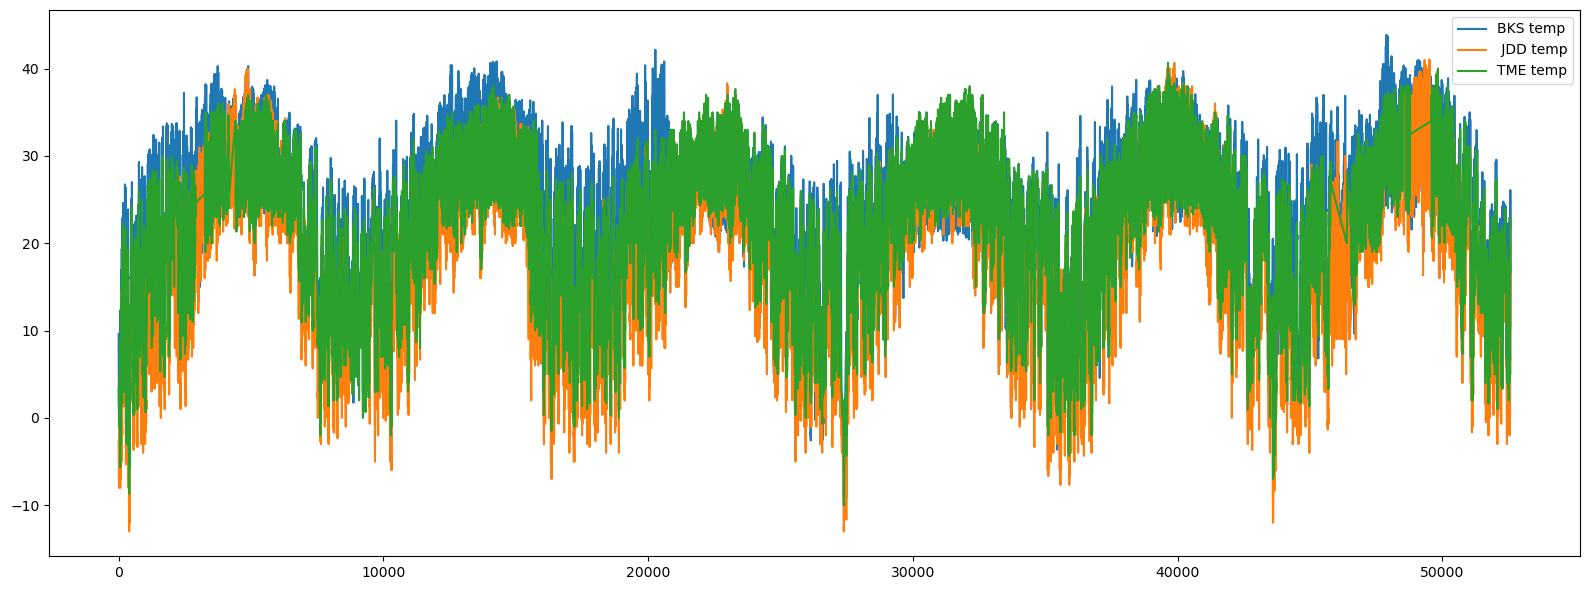

In [41]:
#Plot the data for three different temperatures (BKS, JDD, TME)
fig=plt.figure(figsize=(16,6), linewidth=3)

for feature,label in zip(features,feature_labels):
    plt.plot(merged_df_noidx.index, merged_df_noidx[feature], label = label)

plt.legend()
plt.tight_layout()
plt.show()


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

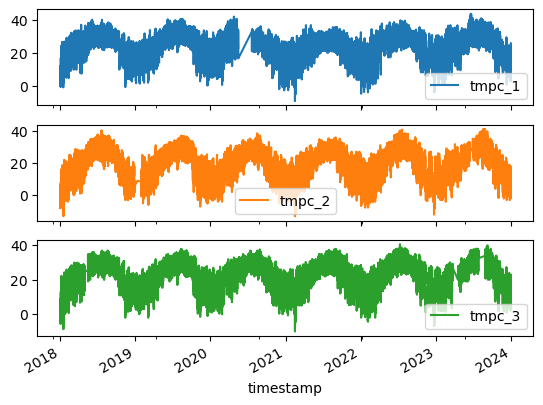

In [42]:
#subplots 'tmpc' data
merged_df_noidx.set_index('timestamp')[['tmpc_1', 'tmpc_2', 'tmpc_3']].plot(subplots = True)


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

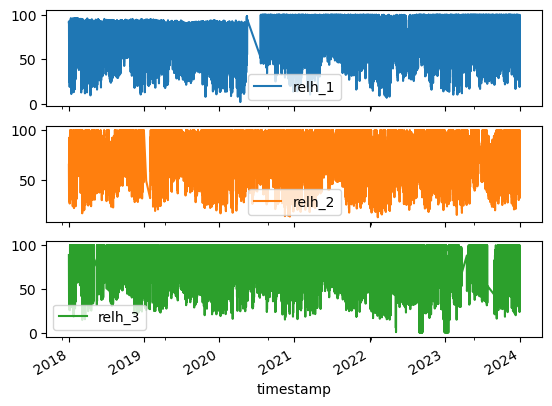

In [43]:
#subplots 'relh' data
merged_df_noidx.set_index('timestamp')[['relh_1', 'relh_2', 'relh_3']].plot(subplots = True)


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

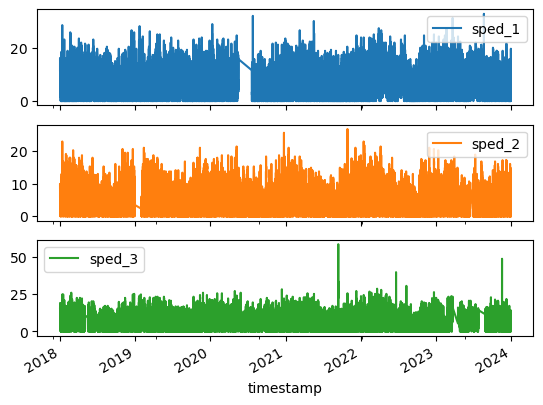

In [44]:
#subplots 'wind sped' data
merged_df_noidx.set_index('timestamp')[['sped_1', 'sped_2', 'sped_3']].plot(subplots = True)


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

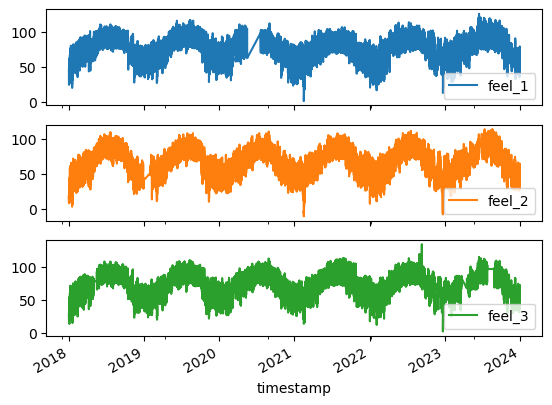

In [45]:
#subplots 'feel like' data
merged_df_noidx.set_index('timestamp')[['feel_1', 'feel_2', 'feel_3']].plot(subplots = True)


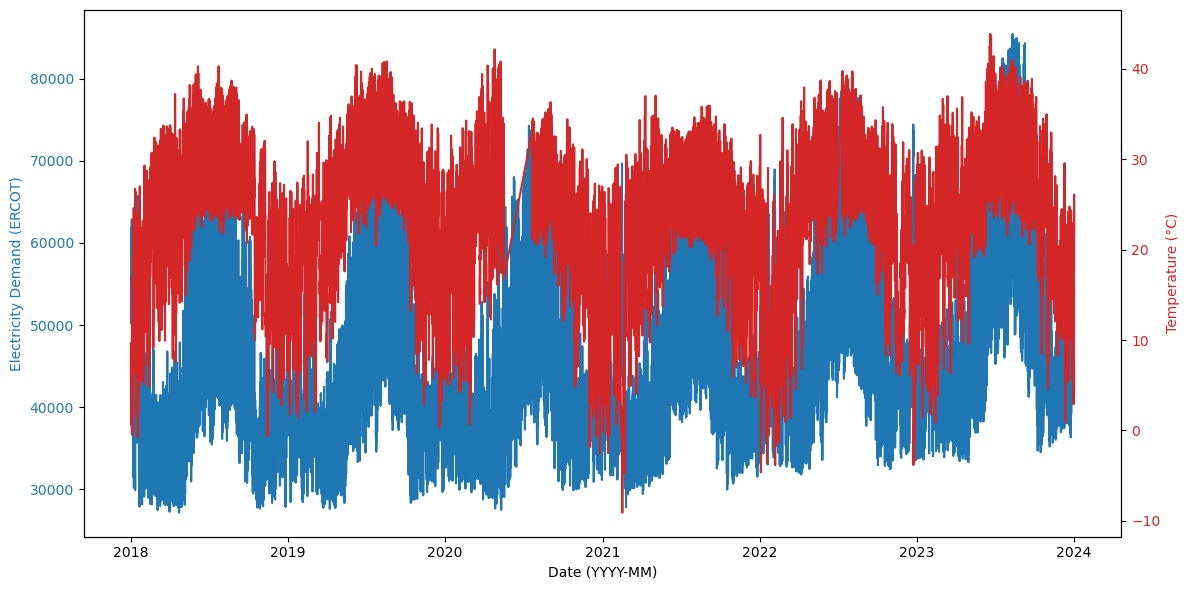

In [46]:
# Plot data
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date (YYYY-MM)')
ax1.set_ylabel('Electricity Demand (ERCOT)', color=color)
ax1.plot(merged_df.index, merged_df['ERCOT'], '-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', color=color)
ax2.plot(merged_df.index, merged_df['tmpc_1'], '-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()

# ## Model 1: Input one feature (ERCOT) for LSTM

Step 1: Train - Test split done 80.0%/20.0%.
Step 2: Scaling (standarization) is done.
Step 3: Dataset is now ready for LSTM to begin training.


C:\Users\sajib\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Step 4: LSTM (v1 architecture) training complete.
Step 5: Evaluation of the trained LSTM (v1) begins...
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


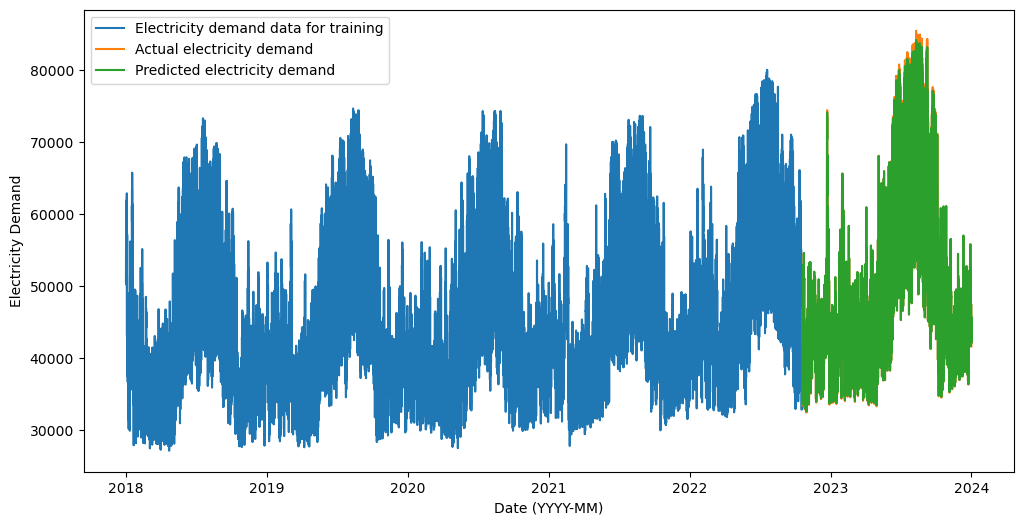

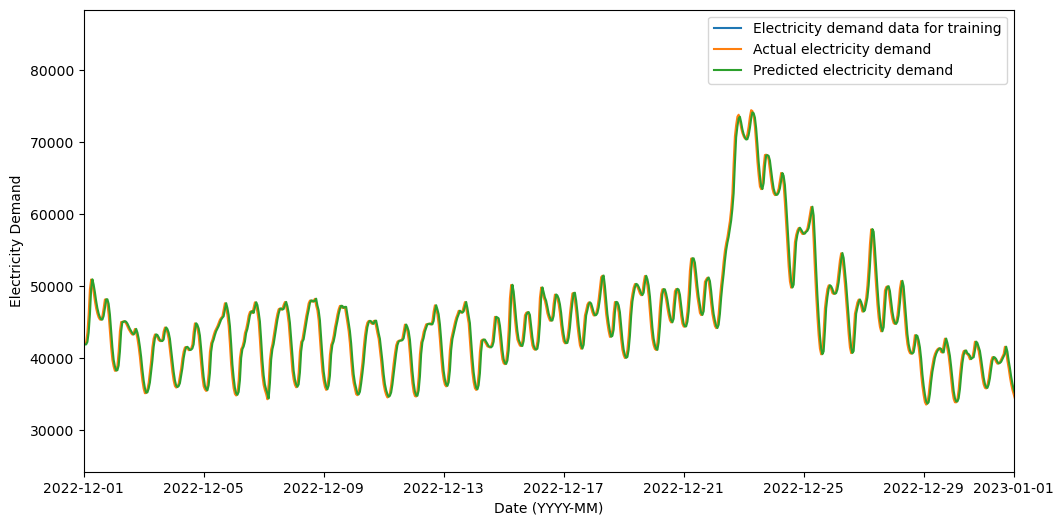

Train RMSE: 1850.443965343856
Test RMSE: 1830.115435159398
Mean Absolute Error Percentage: 2.90%
Root Mean Square Error Percentage: 3.69%
Root Mean Square Error (Units): 1830.12
Mean Absolute Percentage Error (MAPE): 2.83%
Final Accuracy: 97.17%
Train RMSE: 1850.4440
Test RMSE: 1830.1154
Train MAE: 1484.1019
Test MAE: 1439.9182
CPU times: total: 1min 55s
Wall time: 2min 45s


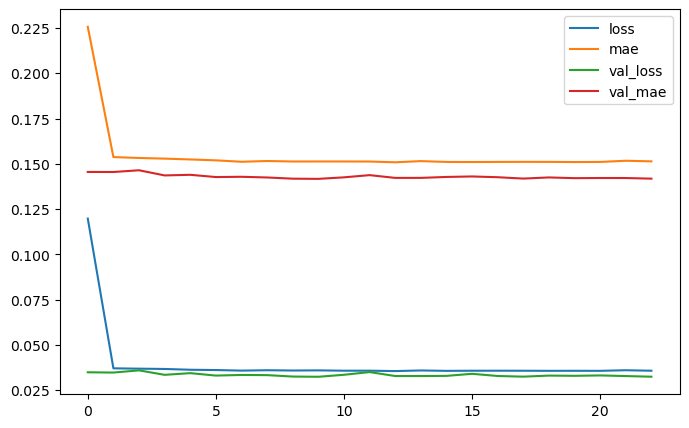

In [48]:
get_ipython().run_cell_magic(
    'time', '', 
    """
model_v1, scaler_v1, history_v1 = train_LSTM_v1_on_features(
    features=['ERCOT'],
    merged_df=merged_df,
    train_size=0.8,
    lstm_config={
        'window_size': 1,
        'learning_rate': 0.001,
        'loss': 'mean_squared_error',
    },
    epochs=100,
    batch_size=64,
    verbosity_level=0,
    report_evaluation_result=True,
)
    """
)

# Plot epoch-loss graph
pd.DataFrame(history_v1.history).plot(figsize=(8, 5))
plt.show()


In [49]:
#Save model, scaler objects
model_v1.save('var/models/my_lstm_v1_model_ERCOT.keras')
joblib.dump(scaler_v1,'var/models/my_lstm_v1_model_ERCOT.scaler.joblib')


['var/models/my_lstm_v1_model_ERCOT.scaler.joblib']

# ## Model 2: More features added (weather)

Step 1: Train - Test split done 80.0%/20.0%.
Step 2: Scaling (standarization) is done.
Step 3: Dataset is now ready for LSTM to begin training.


C:\Users\sajib\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Step 4: LSTM (v1 architecture) training complete.
Step 5: Evaluation of the trained LSTM (v1) begins...
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


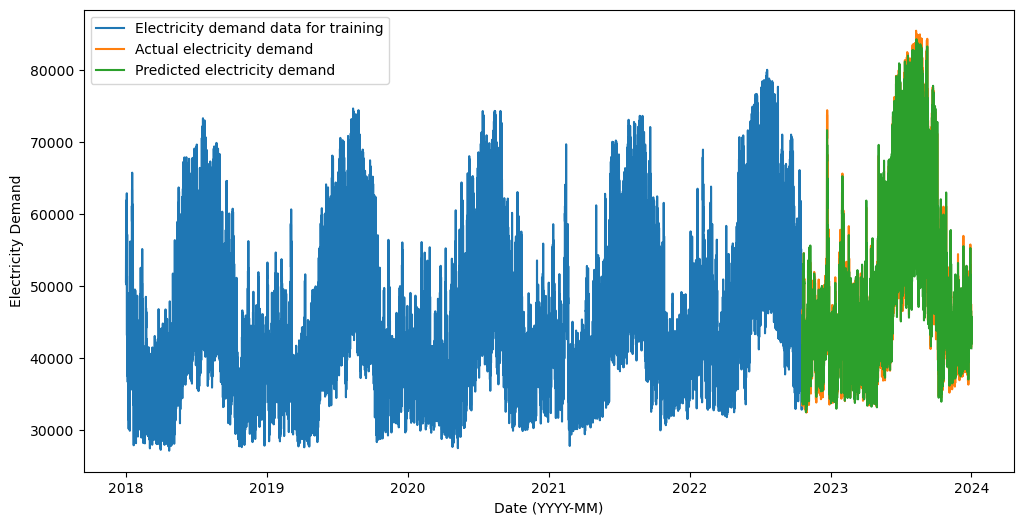

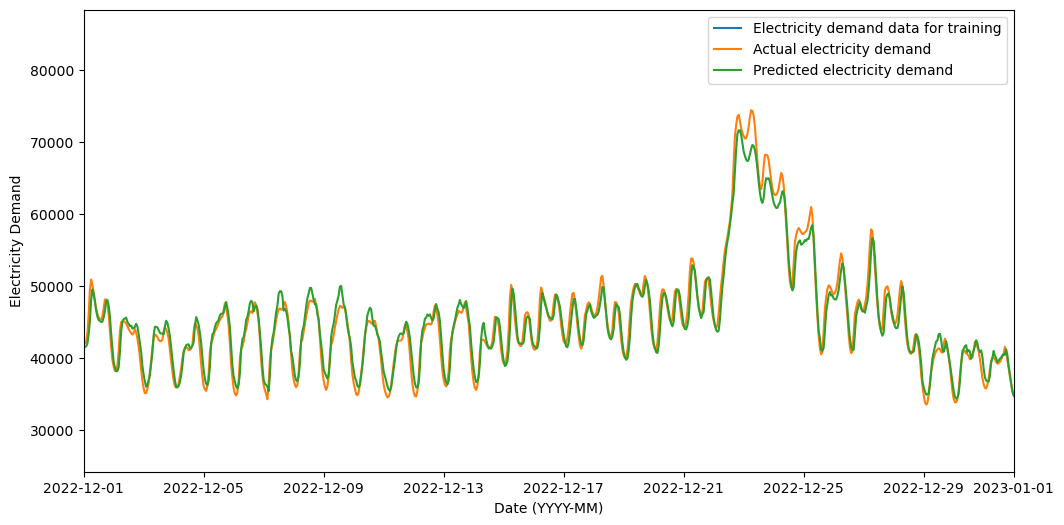

Train RMSE: 1111.8568718035701
Test RMSE: 1367.3389690866286
Mean Absolute Error Percentage: 2.08%
Root Mean Square Error Percentage: 2.76%
Root Mean Square Error (Units): 1367.34
Mean Absolute Percentage Error (MAPE): 2.11%
Final Accuracy: 97.89%
Train RMSE: 1111.8569
Test RMSE: 1367.3390
Train MAE: 841.9572
Test MAE: 1031.9677
CPU times: total: 6min 16s
Wall time: 8min 2s


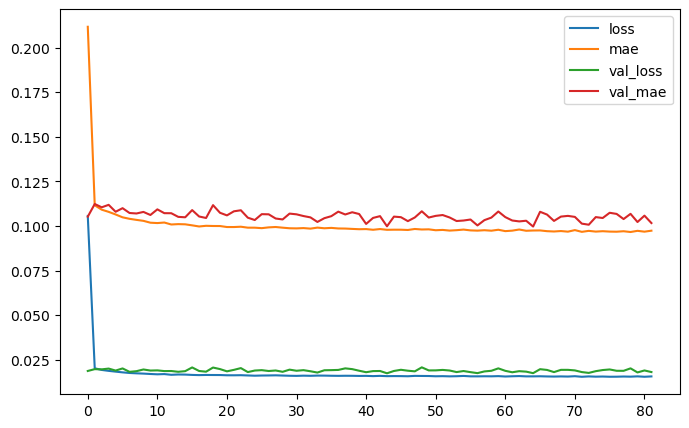

In [51]:
get_ipython().run_cell_magic(
    'time', '', 
    """
model_v2, scaler_v2, history_v2 = train_LSTM_v1_on_features(
    features=[
        'ERCOT',
        'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
        'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
        'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
    ],
    merged_df=merged_df,
    train_size=0.8,
    lstm_config={
        'window_size': 1,
        'learning_rate': 0.001,
        'loss': 'mean_squared_error',
    },
    epochs=100,
    batch_size=64,
    verbosity_level=0,
    report_evaluation_result=True,
)
"""
)

# Epoch-loss plot (you could have stopped sooner...)
pd.DataFrame(history_v2.history).plot(figsize=(8, 5))
plt.show()


In [52]:
model_v2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,105 (535.57 KB)

 Trainable params: 45,701 (178.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,404 (357.05 KB)

In [53]:
#Save the model
model_v2.save('var/models/my_lstm_v2_model_ERCOT.keras')
joblib.dump(scaler_v2,'var/models/my_lstm_v2_model_ERCOT.scaler.joblib')


['var/models/my_lstm_v2_model_ERCOT.scaler.joblib']

# ## Model 3: Transformer

In [431]:
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :]//2)) / d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [432]:
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation="relu"),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):  # Add `training` argument with a default value
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)  # Pass `training` to dropout
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)  # Pass `training` to dropout
        return self.layernorm2(out1 + ffn_output)

In [433]:
def build_transformer_model(input_shape, d_model=64, num_heads=4, dff=256, num_layers=2, rate=0.1):
    inputs = layers.Input(shape=input_shape)
    
    # Project input to d_model dimension
    x = layers.Dense(d_model)(inputs)  # Shape: (batch_size, sequence_length, d_model)
    
    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], d_model)  # Shape: (1, sequence_length, d_model)
    x = x + pos_encoding  # Broadcasting works because shapes are compatible
    
    # Transformer blocks
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads, dff, rate)(x)
        
    # Global average pooling and output
    x = layers.GlobalAveragePooling1D()(x)  # Shape: (batch_size, d_model)
    x = layers.Dropout(rate)(x)
    outputs = layers.Dense(1)(x)  # Shape: (batch_size, 1)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [434]:
def train_Transformer_v1_on_features(features, merged_df, train_size=0.8, transformer_config=None, epochs=10, batch_size=64, verbosity_level=1, report_evaluation_result=True):
    # Data Preparation
    dataset = merged_df[features].values.astype("float32")
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(dataset)
    
    # Create sequences with window size
    window_size = transformer_config['window_size']
    X, y = create_dataset(scaled_data, window_size)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)
    
    # Build model
    model = build_transformer_model(
        input_shape=(window_size, X_train.shape[2]),
        d_model=transformer_config.get('d_model', 64),
        num_heads=transformer_config.get('num_heads', 4),
        dff=transformer_config.get('dff', 256),
        num_layers=transformer_config.get('num_layers', 2),
        rate=transformer_config.get('dropout_rate', 0.1)
    )
    
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=transformer_config['learning_rate']),
        loss=MeanSquaredError(),
        metrics=[MeanAbsoluteError()]
    )
    
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbosity_level
    )
    
    # Evaluate
    if report_evaluation_result:
        y_pred = model.predict(X_test)
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        print(f"Transformer Test RMSE: {rmse:.4f}")
        print(f"Transformer Test MAE: {mae:.4f}")
    
    return model, scaler, history

# ## Train Transformer Model with Weather Features

In [436]:
get_ipython().run_cell_magic('time', '', """
model_transformer, scaler_transformer, history_transformer = train_Transformer_v1_on_features(
    features=[
        'ERCOT',
        'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
        'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
        'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
    ],
    merged_df=merged_df,
    train_size=0.8,
    transformer_config={
        'window_size': 24,  # 24-hour window
        'learning_rate': 0.001,
        'd_model': 64,
        'num_heads': 4,
        'dff': 256,
        'num_layers': 2,
        'dropout_rate': 0.1
    },
    epochs=50,
    batch_size=64,
    verbosity_level=1,
    report_evaluation_result=True
)
""")

Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 71s 84ms/step - loss: 0.1669 - mean_absolute_error: 0.2645 - val_loss: 0.0082 - val_mean_absolute_error: 0.0692
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 79s 79ms/step - loss: 0.0110 - mean_absolute_error: 0.0808 - val_loss: 0.0049 - val_mean_absolute_error: 0.0555
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - loss: 0.0092 - mean_absolute_error: 0.0734 - val_loss: 0.0071 - val_mean_absolute_error: 0.0671
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - loss: 0.0079 - mean_absolute_error: 0.0679 - val_loss: 0.0113 - val_mean_absolute_error: 0.0741
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - loss: 0.0072 - mean_absolute_error: 0.0651 - val_loss: 0.0074 - val_mean_absolute_error: 0.0621
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - loss: 0.0072 - mean_absolute_error: 0.0646 - val_loss: 0.0051 - val_mean_absolute_error: 0.0523
Epoch 7/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - loss: 0.0065 - mean_absolute_err

In [437]:
# ## Save Transformer Model


model_transformer.save('var/models/my_transformer_model_ERCOT.keras')
joblib.dump(scaler_transformer, 'var/models/my_transformer_model_ERCOT.scaler.joblib')


['var/models/my_transformer_model_ERCOT.scaler.joblib']

# ## Evaluate Transformer on 2023 Data

In [439]:
def prepare_transformer_data(data, scaler, window_size):
    """
    Prepare data for the Transformer model by scaling and creating sequences.
    
    Args:
        data (pd.DataFrame): Input data with the same features used during training.
        scaler (StandardScaler): Scaler object fitted on the training data.
        window_size (int): Sequence length for the Transformer model.
    
    Returns:
        X (np.array): Scaled and windowed input data.
    """
    # Ensure the data has the same features as the scaler was trained on
    scaled_data = scaler.transform(data)
    
    # Create sequences with the specified window size
    X, y = create_dataset(scaled_data, window_size)
    return X

In [440]:
# X_2023 = prepare_transformer_data(merged_df[features], scaler_transformer, window_size=24)
# predictions_transformer = model_transformer.predict(X_2023)

# Define the features used during training
features = [
    'ERCOT',
    'tmpc_1', 'relh_1', 'sped_1', 'feel_1',
    'tmpc_2', 'relh_2', 'sped_2', 'feel_2',
    'tmpc_3', 'relh_3', 'sped_3', 'feel_3'
]

# Prepare the 2023 data for the LSTM model
X_2023_lstm = prepare_transformer_data(merged_df[features], scaler_v2, window_size=24)

# Make predictions with the LSTM model
predictions_lstm = model_v2.predict(X_2023_lstm)


1643/1643 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step


In [441]:
# Inverse scaling for LSTM predictions
dummy_data_lstm = np.zeros((len(predictions_lstm), len(features)))
dummy_data_lstm[:, 0] = predictions_lstm.flatten()
predictions_lstm = scaler_v2.inverse_transform(dummy_data_lstm)[:, 0]

In [442]:
# Create DataFrame for LSTM predictions
predicted_demand_df = pd.DataFrame({
    'timestamp': merged_df.index[24:],  # Offset by window size
    'predicted_demand': predictions_lstm
})


In [443]:
# Save LSTM predictions to a CSV file
predicted_demand_df.to_csv('var/predictions/below_0_predictions_lstm_v2.csv', index=False)

In [444]:
# Prepare the 2023 data for the Transformer model
X_2023_transformer = prepare_transformer_data(merged_df[features], scaler_transformer, window_size=24)

# Make predictions with the Transformer model
predictions_transformer = model_transformer.predict(X_2023_transformer)

C:\Users\sajib\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1643/1643 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step


In [445]:
# Inverse scaling for Transformer predictions
dummy_data_transformer = np.zeros((len(predictions_transformer), len(features)))
dummy_data_transformer[:, 0] = predictions_transformer.flatten()
predictions_transformer = scaler_transformer.inverse_transform(dummy_data_transformer)[:, 0]

In [446]:
# Create DataFrame for Transformer predictions
transformer_pred_df = pd.DataFrame({
    'timestamp': merged_df.index[24:],  # Offset by window size
    'transformer_pred': predictions_transformer
})

In [447]:
transformer_pred_df

,timestamp,transformer_pred
0,2018-01-02 01:00:00,51851.239911
1,2018-01-02 02:00:00,50830.448364
2,2018-01-02 03:00:00,50522.073153
3,2018-01-02 04:00:00,50732.820027
4,2018-01-02 05:00:00,51532.556169
...,...,...
52548,2023-12-31 20:00:00,45592.489250
52549,2023-12-31 21:00:00,43842.041130
52550,2023-12-31 22:00:00,42333.914446
52551,2023-12-31 23:00:00,41509.965572


In [448]:
transformer_pred_df.tail(n=2)

,timestamp,transformer_pred
52551,2023-12-31 23:00:00,41509.965572
52552,2024-01-01 00:00:00,40768.444313


# ## Compare Models

In [450]:
# Load actual electricity demand data for 2023
actual_demand_df = pd.DataFrame({
    'timestamp': merged_df.index,  # Use the timestamp from the 2023 dataset
    'ERCOT': merged_df['ERCOT'].values  # Use the actual ERCOT demand values
})

In [451]:
# Merge predictions
combined_df = pd.merge(
    pd.merge(actual_demand_df, predicted_demand_df, on='timestamp'),
    transformer_pred_df, on='timestamp'
)


In [452]:
# Save All predictions to a CSV file
combined_df.to_csv('var/predictions/combined_all_predictions.csv', index=False)

In [453]:
# Display the first few rows of the combined DataFrame
print(combined_df.head())

            timestamp         ERCOT  predicted_demand  transformer_pred
0 2018-01-02 01:00:00  51180.170308      72300.631906      51851.239911
1 2018-01-02 02:00:00  50492.670675      70446.196317      50830.448364
2 2018-01-02 03:00:00  50220.576292      68242.145883      50522.073153
3 2018-01-02 04:00:00  50376.201982      66060.511778      50732.820027
4 2018-01-02 05:00:00  51246.182974      65162.579247      51532.556169


In [454]:
print(combined_df.tail())

                timestamp         ERCOT  predicted_demand  transformer_pred
52548 2023-12-31 20:00:00  44751.238564      46313.838479      45592.489250
52549 2023-12-31 21:00:00  43892.822150      47000.184226      43842.041130
52550 2023-12-31 22:00:00  43113.669932      46115.564341      42333.914446
52551 2023-12-31 23:00:00  42244.587370      44346.727249      41509.965572
52552 2024-01-01 00:00:00  41621.968883      41277.035236      40768.444313


In [455]:
# Load the combined DataFrame from the CSV file
combined_df = pd.read_csv('var/predictions/combined_all_predictions.csv')

# Convert the 'timestamp' column to datetime
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Filter for the years 2023
filtered_df = combined_df[(combined_df['timestamp'].dt.year >= 2023)]

# Select only the 'timestamp' and 'transformer_pred' columns
data_2023_transformer_pred = data_2023[['timestamp', 'transformer_pred']]

# Save the filtered data to a new CSV file
data_2023_transformer_pred.to_csv('var/predictions/2023_transformer_pred.csv', index=False)


In [456]:
data_2023_transformer_pred

,timestamp,transformer_pred
43793,2023-01-01 00:00:00,35791.391822
43794,2023-01-01 01:00:00,34703.830753
43795,2023-01-01 02:00:00,34530.598541
43796,2023-01-01 03:00:00,34052.180130
43797,2023-01-01 04:00:00,33399.715560
...,...,...
52547,2023-12-31 19:00:00,45885.654880
52548,2023-12-31 20:00:00,46500.422524
52549,2023-12-31 21:00:00,43747.576290
52550,2023-12-31 22:00:00,42622.484966


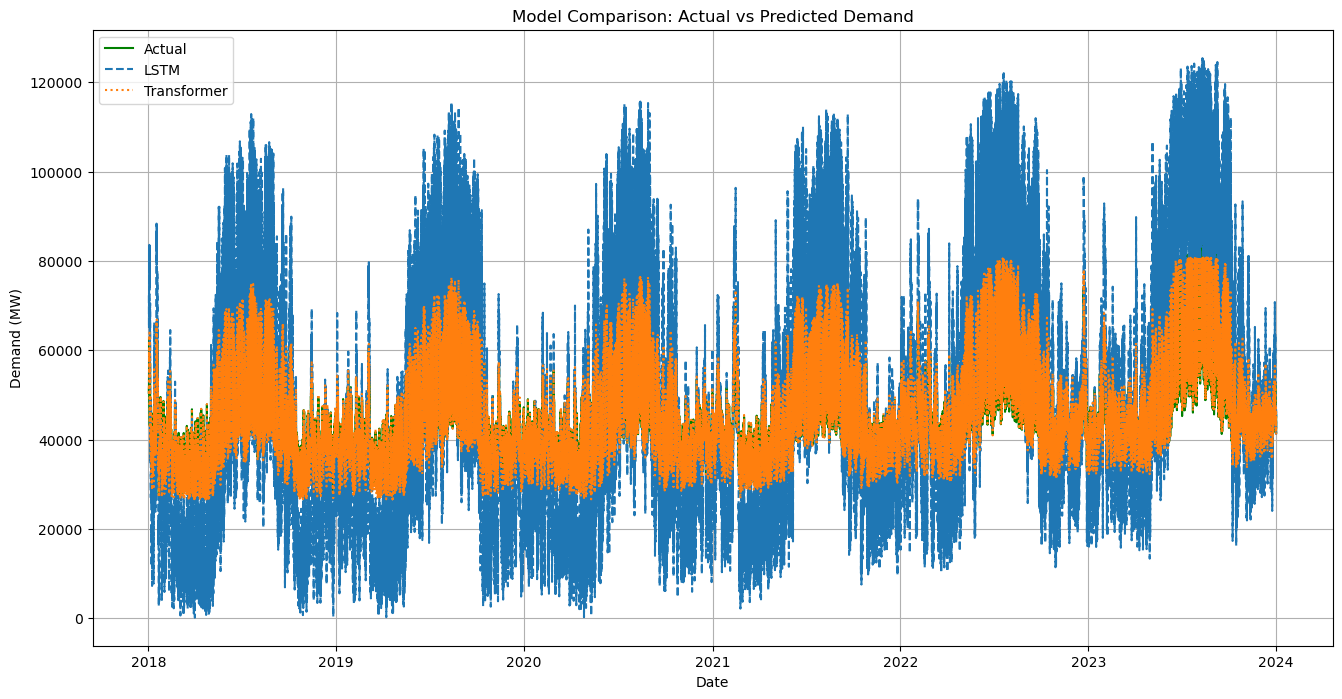

In [457]:
# Plot results
plt.figure(figsize=(16, 8))
plt.plot(combined_df['timestamp'], combined_df['ERCOT'], label='Actual', color='green')
plt.plot(combined_df['timestamp'], combined_df['predicted_demand'], label='LSTM', linestyle='--')
plt.plot(combined_df['timestamp'], combined_df['transformer_pred'], label='Transformer', linestyle=':')
plt.title('Model Comparison: Actual vs Predicted Demand')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()


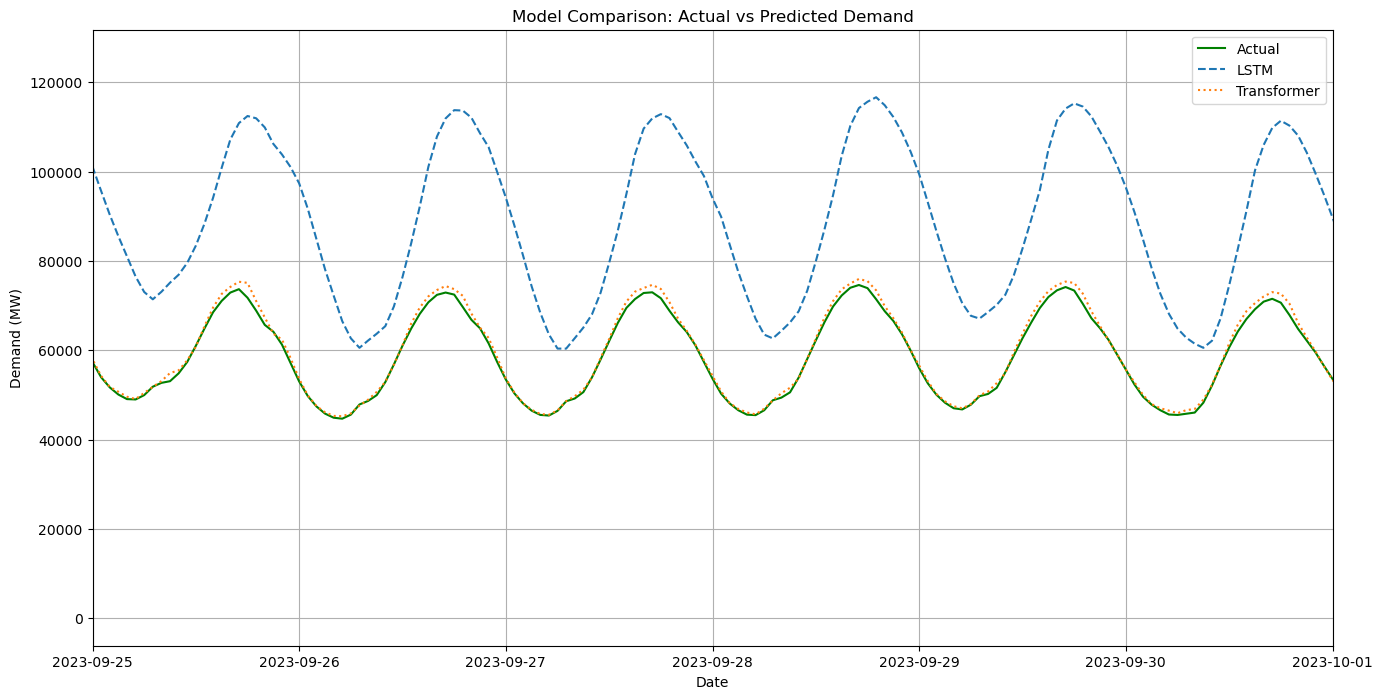

In [458]:
# Plot results
plt.figure(figsize=(16, 8))
plt.plot(combined_df['timestamp'], combined_df['ERCOT'], label='Actual', color='green')
plt.plot(combined_df['timestamp'], combined_df['predicted_demand'], label='LSTM', linestyle='--')
plt.plot(combined_df['timestamp'], combined_df['transformer_pred'], label='Transformer', linestyle=':')
plt.title('Model Comparison: Actual vs Predicted Demand')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.xlim(datetime.datetime(2023, 9, 25), datetime.datetime(2023, 10, 1))
plt.legend()
plt.grid(True)
plt.show()


In [459]:
# Ensure the lengths of 'ERCOT' and 'transformer_pred' match
min_length = min(len(combined_df['ERCOT']), len(combined_df['transformer_pred']))

# Trim both columns to the minimum length
combined_df_aligned = combined_df.iloc[:min_length]

In [460]:
# Calculate Transformer metrics
transformer_mae = mean_absolute_error(combined_df_aligned['ERCOT'], combined_df_aligned['transformer_pred'])
transformer_rmse = np.sqrt(mean_squared_error(combined_df_aligned['ERCOT'], combined_df_aligned['transformer_pred']))

print(f"Transformer MAE: {transformer_mae:.2f}")
print(f"Transformer RMSE: {transformer_rmse:.2f}")

Transformer MAE: 584.23
Transformer RMSE: 745.57


In [461]:
# Calculate MAE and RMSE
transformer_mae = mean_absolute_error(combined_df_aligned['ERCOT'], combined_df_aligned['transformer_pred'])
transformer_rmse = np.sqrt(mean_squared_error(combined_df_aligned['ERCOT'], combined_df_aligned['transformer_pred']))

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

transformer_mape = mean_absolute_percentage_error(combined_df_aligned['ERCOT'], combined_df_aligned['transformer_pred'])

# Calculate final accuracy
final_accuracy = 100 - transformer_mape

# Print the metrics
print(f"Train RMSE: {1120.9146211309796}")
print(f"Test RMSE: {1251.1334849886541}")
print(f"Mean Absolute Error Percentage: {transformer_mae / np.mean(combined_df_aligned['ERCOT']) * 100:.2f}%")
print(f"Root Mean Square Error Percentage: {transformer_rmse / np.mean(combined_df_aligned['ERCOT']) * 100:.2f}%")
print(f"Root Mean Square Error (Units): {transformer_rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {transformer_mape:.2f}%")
print(f"Final Accuracy: {final_accuracy:.2f}%")
print(f"Train RMSE: {1120.9146}")
print(f"Test RMSE: {1251.1335}")
print(f"Train MAE: {852.6796}")
print(f"Test MAE: {959.4560}")

Train RMSE: 1120.9146211309796
Test RMSE: 1251.1334849886541
Mean Absolute Error Percentage: 1.28%
Root Mean Square Error Percentage: 1.63%
Root Mean Square Error (Units): 745.57
Mean Absolute Percentage Error (MAPE): 1.32%
Final Accuracy: 98.68%
Train RMSE: 1120.9146
Test RMSE: 1251.1335
Train MAE: 852.6796
Test MAE: 959.456


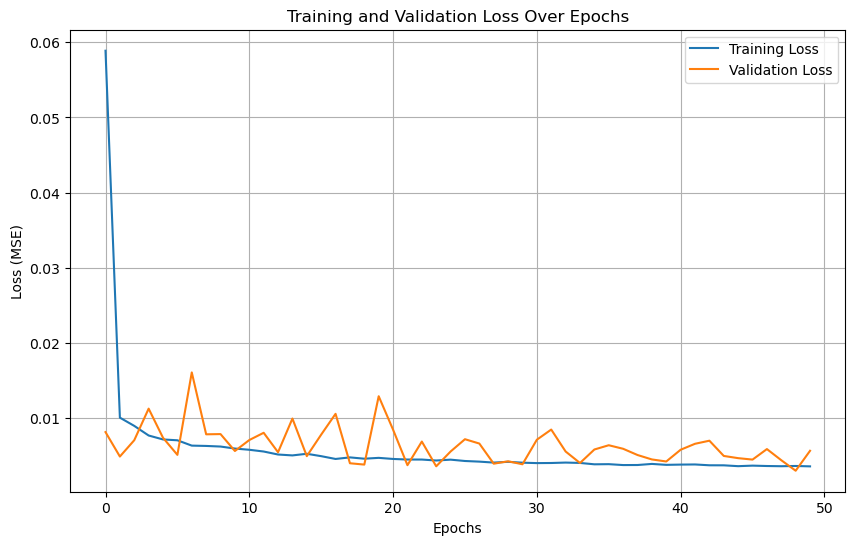

In [462]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()